# Memory plots for Tegrastats logs

#### Globals and imports

In [149]:
import re
import matplotlib.pyplot as plt

### Functions

In [150]:
# Función para analizar una línea de estadísticas
# 03-17-2024 18:54:10 RAM 10239/62841MB (lfb 442x4MB) SWAP 1/31421MB (cached 0MB) CPU [0%@1728,0%@1728,0%@1728,0%@1728,0%@1420,0%@1420,0%@1420,0%@1420,off,off,off,off] GR3D_FREQ 0% cpu@37.5C tboard@27C soc2@34.562C tdiode@27.5C soc0@34.531C tj@37.5C soc1@33.656C VDD_GPU_SOC 1592mW/1592mW VDD_CPU_CV -398mW/-398mW VIN_SYS_5V0 2624mW/2624mW VDDQ_VDD2_1V8AO 403mW/403mW
def parse_line(line):
    stats = {}
    parts = line.split()
    stats['time'] = parts[0] + ' ' + parts[1]
    stats['RAM'] = int(parts[3].split('/')[0])
    stats['maxRAM'] = int(parts[3].split('/')[1].split('M')[0])
    stats['SWAP'] = int(parts[7].split('/')[0])
    stats['maxSWAP'] = int(parts[7].split('/')[1].split('M')[0])
    stats['CPU'] = parts[11].strip('[]').split(',')
    stats['GR3D_FREQ'] = int(parts[13].split('%')[0])
    # Agrega aquí más métricas según sea necesario.
    return stats

In [151]:
# Leer datos de los archivos y almacenar en diccionarios
def read_data(file_path):
    data = {'time': [], 'RAM': [], 'SWAP': [], 'GR3D_FREQ': [], 'CPU': [], 'CPU_FREQ': [], 'maxRAM': 0, 'maxSWAP': 0}
    with open(file_path, 'r') as file:
        first_line = True
        time_ms = 0  # Inicializa el contador de tiempo en 0
        for line in file:
            if line.strip():
                stats = parse_line(line)
                if first_line:
                    # Extrae maxRAM y maxSWAP solo de la primera línea
                    data['maxRAM'] = stats['maxRAM']
                    data['maxSWAP'] = stats['maxSWAP']
                    first_line = False
                 # Calcula el promedio del uso de CPU y la frecuencia
                cpu_usage_sum = 0
                cpu_freq_sum = 0
                cpu_count = 0
                for cpu in stats['CPU']:
                    if cpu != 'off':
                        usage, freq = cpu.split('@')
                        cpu_usage_sum += int(usage[:-1])  # Elimina el signo % y convierte a int
                        cpu_freq_sum += int(freq)
                        cpu_count += 1
                
                # Solo añade valores si hay CPUs activos
                if cpu_count > 0:
                    avg_cpu_usage = cpu_usage_sum / cpu_count
                    avg_cpu_freq = cpu_freq_sum / cpu_count
                else:
                    avg_cpu_usage = 0
                    avg_cpu_freq = 0

                data['CPU'].append(avg_cpu_usage)
                data['CPU_FREQ'].append(avg_cpu_freq)
                data['time'].append(time_ms)
                data['RAM'].append(stats['RAM'])
                data['SWAP'].append(stats['SWAP'])
                data['GR3D_FREQ'].append(stats['GR3D_FREQ'])
                # Incrementa el contador de tiempo en 1 milisegundo para el siguiente registro
                time_ms += 1 # estamos probando tegrastats a una taza de sampleo de 1 ms
    return data

In [152]:
def plot_memory_raw(metrics, labels, title):
    # Extraer maxRAM y maxSWAP de los datos (asumiendo que son constantes)
    maxRAM = metrics[0]['maxRAM'] / 1024  # Convertir de MB a GB
    maxSWAP = metrics[0]['maxSWAP'] / 1024  # Convertir de MB a GB

    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 7)).tight_layout()
    color_dict = {'Vanilla':'tab:blue', 'TRT fp32':'tab:orange', 'TRT fp16':'tab:green', 'TRT int8':'tab:red'}  # Añadir más etiquetas si es necesario

    # Graficar RAM
    for index, (metric, label) in enumerate(zip(metrics, labels)):
        ram_in_gb = [ram / 1024 for ram in metric['RAM']]  # Convertir RAM a GB
        color = color_dict.get(label, None)  # Obtener color del diccionario o usar el predeterminado
        plt.plot(metric['time'], ram_in_gb, label=f'RAM {label}', color=color)
        max_ram = max(ram_in_gb)
        avg_ram = sum(ram_in_gb) / len(ram_in_gb)

        #print(f'Max RAM {label}: {max_ram:.2f} GB, Avg RAM {label}: {avg_ram:.2f} GB')

    # Graficar SWAP
    for index, (metric, label) in enumerate(zip(metrics, labels)):
        swap_in_gb = [swap / 1024 for swap in metric['SWAP']]  # Convertir SWAP a GB
        color = color_dict.get(label, None)  # Obtener el mismo color para la misma etiqueta
        plt.plot(metric['time'], swap_in_gb, label=f'SWAP {label}', linestyle='--', color=color)  # Línea punteada para SWAP
        max_swap = max(swap_in_gb)
        avg_swap = sum(swap_in_gb) / len(swap_in_gb)

        #print(f'Max SWAP {label}: {max_swap:.2f} GB, Avg SWAP {label}: {avg_swap:.2f} GB')

    # Configurar título y etiquetas
    
    plt.title(f'{title} - RAM and SWAP Usage')
    plt.xlabel('Time ms')
    plt.ylabel('Usage (GB)')
    plt.ylim(0, max(maxRAM, maxSWAP))  # Asegurar que el eje Y sea adecuado para ambas series
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Mostrar gráfico
    plt.show()


In [153]:
def plot_memory_over_batch_size(data_dicts, batch_sizes):
    """
    Plots average and maximum RAM and SWAP usage for multiple neural network models and prints max RAM and SWAP usage.
    
    Parameters:
    - data_dicts: List of dictionaries containing resource usage data.
    - batch_sizes: List of batch sizes corresponding to each dictionary.
    """
    maxRAM = data_dicts[0]['maxRAM'] / 1024  # Convertir de MB a GB
    maxSWAP = data_dicts[0]['maxSWAP'] / 1024  # Convertir de MB a GB
    avg_ram_usage = []
    max_ram_usage = []
    avg_swap_usage = []
    max_swap_usage = []
    valid_batch_sizes_ram = []
    valid_batch_sizes_swap = []

    # Recorrer los diccionarios de datos y calcular los promedios y máximos
    for index, (data, label) in enumerate(zip(data_dicts, batch_sizes)):
        # Calcular el uso promedio y máximo de RAM
        ram_in_gb = [ram / 1024 for ram in data['RAM']]
        if len(ram_in_gb) > 0 and sum(ram_in_gb) > 0:  # Verificar que no sea una lista vacía o llena de ceros
            avg_ram = sum(ram_in_gb) / len(ram_in_gb)
            max_ram = max(ram_in_gb)
            avg_ram_usage.append(avg_ram)
            max_ram_usage.append(max_ram)
            valid_batch_sizes_ram.append(label)  # Solo incluir batch sizes con datos válidos
        
        # Calcular el uso promedio de SWAP
        if any(data['SWAP']):  # Verifica si hay algún uso de SWAP
            avg_swap = sum(data['SWAP']) / len(data['SWAP'])
            max_swap = max(data['SWAP'])
            avg_swap_usage.append(avg_swap)
            max_swap_usage.append(max_swap)
            valid_batch_sizes_swap.append(label)  # Solo incluir batch sizes con datos válidos

    # Plot RAM usage si hay datos válidos
    if valid_batch_sizes_ram:
        plt.rcParams.update({'font.size': 10})
        plt.figure(figsize=(5, 3.5)).tight_layout()
        plt.plot(valid_batch_sizes_ram, avg_ram_usage, label='Average RAM Usage', marker='o', color='tab:blue')
        plt.plot(valid_batch_sizes_ram, max_ram_usage, label='Max RAM Usage', linestyle='--', marker='o', color='tab:blue')
        plt.fill_between(valid_batch_sizes_ram, avg_ram_usage, max_ram_usage, color='tab:blue', alpha=0.2)  # Área sombreada entre RAM promedio y máxima
        
        
        # Verificar que haya datos válidos para calcular max_ram_limit
        ram_values = [ram / 1024 for data in data_dicts for ram in data['RAM'] if ram > 0]
        if ram_values:
            max_ram_limit = max(ram_values)
            plt.ylim(0, max_ram_limit * 1.1)
        else:
            plt.ylim(0, 8)  # Establecer un límite por defecto si no hay valores válidos 
       
        #plt.ylim(0, 17)
        #plt.xlim(0, 270)

    # Plot SWAP usage si hay datos válidos
    if valid_batch_sizes_swap:
        plt.plot(valid_batch_sizes_swap, avg_swap_usage, label='Average SWAP Usage', marker='x', color='tab:green')
        plt.plot(valid_batch_sizes_swap, max_swap_usage, label='Max SWAP Usage', linestyle='--', marker='x', color='tab:green')
        plt.fill_between(valid_batch_sizes_swap, avg_swap_usage, max_swap_usage, color='tab:green', alpha=0.2)  # Área sombreada entre SWAP promedio y máximo

    plt.xlabel('Batch Size')
    plt.ylabel('Usage (GB)')
    plt.title(f'{PLATFORM} {POWER_MODE} {NETWORK} {OPTIMIZATION}')
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'memory_{PLATFORM}_{POWER_MODE}_{NETWORK}_{OPTIMIZATION}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura
    plt.show()


In [154]:
def plot_memory_single_figure(data_dicts_pm, batch_sizes, labels_name, title):
    """
    Plots average and maximum RAM and SWAP usage for multiple neural network models under different Power Modes.
    
    Parameters:
    - data_dicts_pm: List of lists of dictionaries containing resource usage data for different Power Modes.
    - batch_sizes: List of batch sizes corresponding to each dictionary.
    - labels_name: List of labels to use for the Power Modes.
    """
    
    # Configuración de colores y estilos para diferentes Power Modes
    colors = ['tab:blue', 'tab:orange', 'tab:green',  'tab:red']  # Colores para diferentes Power Modes
    
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(5, 5))
    
    # Recorrer los conjuntos de datos para cada Power Mode
    for pm_index, data_dicts in enumerate(data_dicts_pm):
        avg_ram_usage = []
        max_ram_usage = []
        avg_swap_usage = []
        max_swap_usage = []
        valid_batch_sizes_ram = []
        valid_batch_sizes_swap = []
        
        # Recorrer cada batch size dentro del modo de energía actual
        for index, (data, label) in enumerate(zip(data_dicts, batch_sizes)):
            ram_in_gb = [ram / 1024 for ram in data['RAM']] 
            
            # Verificar que la lista no esté vacía o que no tenga todos sus valores en cero
            if len(ram_in_gb) > 0 and sum(ram_in_gb) > 0:
                avg_ram = sum(ram_in_gb) / len(ram_in_gb)
                max_ram = max(ram_in_gb)
                avg_ram_usage.append(avg_ram)
                max_ram_usage.append(max_ram)
                valid_batch_sizes_ram.append(label)  # Solo agregar el batch size si tiene datos válidos
            #else:
            #    print(f"Advertencia: No hay datos de RAM para el batch size {label} en {labels_name[pm_index]}")
            
            # Calcular el uso promedio de SWAP (convertido a GB)
            if any(swap > 0 for swap in data['SWAP']):  # Validación de uso de SWAP
                swap_in_gb = [swap / 1024 for swap in data['SWAP']]
                avg_swap = sum(swap_in_gb) / len(swap_in_gb)
                max_swap = max(swap_in_gb)
                avg_swap_usage.append(avg_swap)
                max_swap_usage.append(max_swap)
                valid_batch_sizes_swap.append(label)  # Solo agregar el batch size si tiene datos válidos
            #else:
            #    print(f"Advertencia: No hay datos de SWAP para el batch size {label} en {labels_name[pm_index]}")
        
        # Plot RAM usage para el modo de energía actual si hay datos válidos
        if valid_batch_sizes_ram:
            color = colors[pm_index % len(colors)]
            plt.plot(valid_batch_sizes_ram, avg_ram_usage, label=f'Average RAM Usage {labels_name[pm_index]}', marker='o', color=color)
            plt.plot(valid_batch_sizes_ram, max_ram_usage, label=f'Max RAM Usage {labels_name[pm_index]}', linestyle="--", marker='o', color=color)
            plt.fill_between(valid_batch_sizes_ram, avg_ram_usage, max_ram_usage, color=color, alpha=0.2)  # Área sombreada entre RAM promedio y máxima
    
        # Descomentar para SWAP si se requiere
        """
        if valid_batch_sizes_swap:
            plt.plot(valid_batch_sizes_swap, avg_swap_usage, label=f'Average SWAP Usage {labels_name[pm_index]}', marker='x', color=color)
            plt.plot(valid_batch_sizes_swap, max_swap_usage, label=f'Max SWAP Usage {labels_name[pm_index]}', linestyle="--", marker='x', color=color)
            plt.fill_between(valid_batch_sizes_swap, avg_swap_usage, max_swap_usage, color=color, alpha=0.2)
        """

    # Establecer límites en base al 'maxRAM' de los datos
    ram_values = [ram / 1024 for data_dicts in data_dicts_pm for data in data_dicts for ram in data['RAM'] if ram > 0]
    swap_values = [swap / 1024 for data_dicts in data_dicts_pm for data in data_dicts for swap in data['SWAP'] if swap > 0]
    
    if ram_values:
        max_ram_limit = max(ram_values)
    else:
        max_ram_limit = 0
    
    if swap_values:
        max_swap_limit = max(swap_values)
    else:
        max_swap_limit = 0
    
    # Ajustar el límite superior del gráfico para incluir RAM y SWAP si hay datos válidos
    #plt.ylim(0, max(max_ram_limit, max_swap_limit) * 1.1 if max_ram_limit > 0 or max_swap_limit > 0 else 8)  
    plt.ylim(0,17)
    
    # Configuración del gráfico
    plt.xlabel('Batch Size')
    plt.ylabel('RAM Usage (GB)')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
    plt.minorticks_on()
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Memory_{PLATFORM}_{NETWORK}_{OPTIMIZATION}.pdf', format='pdf', bbox_inches='tight')
    plt.show()


In [155]:
def plot_memory_horizontal_plots(data_dicts_list, batch_sizes, plot_titles, legend_labels):
    """
    Plots average and maximum RAM and SWAP usage for multiple sets of neural network models under different Power Modes.
    
    Parameters:
    - data_dicts_list: List of lists containing resource usage data for different Power Modes. Each entry is a list of dictionaries.
    - batch_sizes: List of batch sizes corresponding to each dictionary.
    - plot_titles: List of titles for each Power Mode.
    - legend_labels: List of labels for each data set (e.g., ['Dynamic', 'Static', ...]).
    """
    
    # Colores para cada conjunto de datos (mismos colores para Avg y Max dentro del mismo conjunto de datos)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

    plt.rcParams.update({'font.size': 14})
    num_pm = len(data_dicts_list[0])  # Número de Power Modes (se asume que todos los conjuntos tienen la misma cantidad)
    fig, axs = plt.subplots(1, num_pm, figsize=(5 * num_pm, 5), sharey=True)  # Subplots en una fila, compartiendo el eje Y
    
    # Función auxiliar para realizar el ploteo para ambos conjuntos de datos
    def plot_for_pm(ax, data_dicts, color, batch_sizes, label_prefix):
        avg_ram_usage = []
        max_ram_usage = []
        avg_swap_usage = []
        max_swap_usage = []
        valid_batch_sizes_ram = []
        valid_batch_sizes_swap = []
        
        for index, (data, label) in enumerate(zip(data_dicts, batch_sizes)):
            ram_in_gb = [ram / 1024 for ram in data['RAM']] 
            
            if len(ram_in_gb) > 0 and sum(ram_in_gb) > 0:
                avg_ram = sum(ram_in_gb) / len(ram_in_gb)
                max_ram = max(ram_in_gb)
                avg_ram_usage.append(avg_ram)
                max_ram_usage.append(max_ram)
                valid_batch_sizes_ram.append(label)  # Solo agregar el batch size si tiene datos válidos
            
            if any(swap > 0 for swap in data['SWAP']):  # Validación de uso de SWAP
                swap_in_gb = [swap / 1024 for swap in data['SWAP']]
                avg_swap = sum(swap_in_gb) / len(swap_in_gb)
                max_swap = max(swap_in_gb)
                avg_swap_usage.append(avg_swap)
                max_swap_usage.append(max_swap)
                valid_batch_sizes_swap.append(label)
        
        # Plot RAM usage si hay datos válidos
        if valid_batch_sizes_ram:
            ax.plot(valid_batch_sizes_ram, avg_ram_usage, label=f'Avg RAM {label_prefix}', marker='o', color=color)
            ax.plot(valid_batch_sizes_ram, max_ram_usage, label=f'Max RAM {label_prefix}', linestyle="--", marker='o', color=color)
            ax.fill_between(valid_batch_sizes_ram, avg_ram_usage, max_ram_usage, color=color, alpha=0.2)

    # Recorrer los Power Modes
    for pm_index in range(num_pm):
        ax = axs[pm_index]  # Seleccionar el subplot adecuado
        
        # Para cada conjunto de datos (dynamic, static, etc.)
        for data_index, (data_dicts, legend_label) in enumerate(zip(data_dicts_list, legend_labels)):
            color = colors[data_index % len(colors)]  # Asignar el mismo color a Avg y Max para cada dataset
            plot_for_pm(ax, data_dicts[pm_index], color, batch_sizes, legend_label)
        
        # Solo el primer gráfico muestra el label del eje Y
        if pm_index == 0:
            ax.set_ylabel('RAM Usage (GB)')
        ax.set_xlabel('Batch Size')
        ax.grid(True)
        ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
        ax.minorticks_on()
        
        # Añadir la leyenda solo en el gráfico más a la derecha
        if pm_index == num_pm - 1:
            ax.legend(loc='lower right')

        # Ajustar el rango del eje X de 0 a 270
        ax.set_xlim(0, 270)
        
        # Añadir título personalizado a cada subplot
        ax.set_title(plot_titles[pm_index])

    # Ajustar el límite superior del gráfico para incluir RAM y SWAP si hay datos válidos
    ram_values = [ram / 1024 for data_dicts in data_dicts_list for data in data_dicts if 'RAM' in data for ram in data['RAM'] if ram > 0]
    swap_values = [swap / 1024 for data_dicts in data_dicts_list for data in data_dicts if 'SWAP' in data for swap in data['SWAP'] if swap > 0]
    
    if ram_values:
        max_ram_limit = max(ram_values)
    else:
        max_ram_limit = 0
    
    if swap_values:
        max_swap_limit = max(swap_values)
    else:
        max_swap_limit = 0
    
    # Ajustar el límite superior de todos los gráficos en conjunto
    #plt.ylim(0, max(max_ram_limit, max_swap_limit) * 1.1 if max_ram_limit > 0 or max_swap_limit > 0 else 17)
    plt.ylim(0, 17) 
    # Ajustar el layout
    plt.tight_layout()
    
    # Guardar y mostrar el gráfico
    plt.savefig(f'Memory_{PLATFORM}_{NETWORK}_{OPTIMIZATION}.pdf', format='pdf', bbox_inches='tight')
    plt.show()


# PLOTS

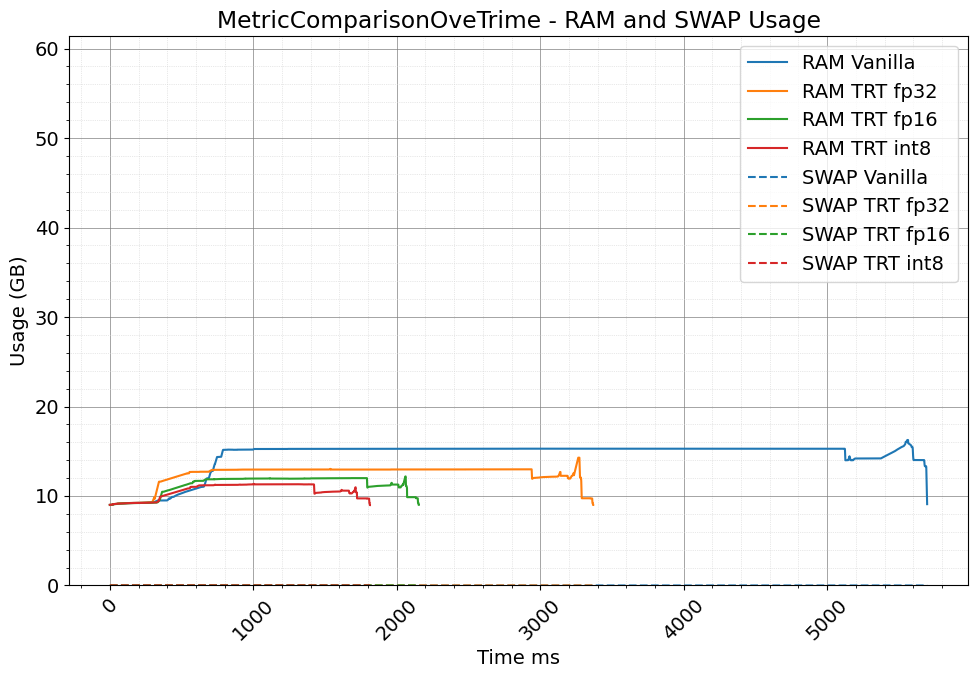

In [156]:
# MEMORY PLOT OVER TIME

PLATFORM = 'orin_agx'
NETWORK = 'resnet152'
BATCH_SIZE = '256'
POWER_MODE = 'PM2'
BUILD_TYPE = 'dynamic'
OPLVL = 'OPLVL3'

data_vanilla =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/vanilla_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_trt_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/fp32_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_trt_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/fp16_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_trt_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/int8_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
# Graficar los datos


plot_memory_raw(
    [ data_vanilla, data_trt_fp32, data_trt_fp16,data_trt_int8],
    [ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT int8'],
    'MetricComparisonOveTrime'
) 

#[ data_vanilla, data_trt_fp32, data_trt_fp16, data_trt_int8],
#[ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT INT8'],

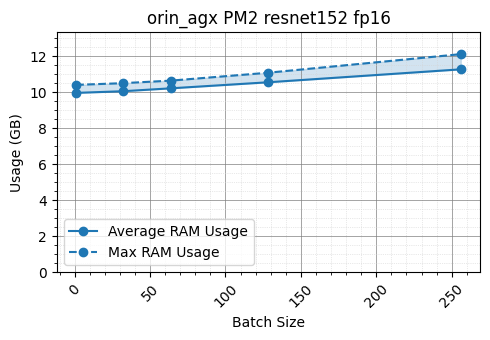

In [157]:
# MEMORY PLOTTER, SINGLE GRAPH

PLATFORM = 'orin_agx'
OPTIMIZATION = 'fp16'
NETWORK = 'resnet152'
POWER_MODE = 'PM2'
BUILD_TYPE = 'static'
OPLVL = 'OPLVL3'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')


# Graficar los datos
plot_memory_over_batch_size(
    [ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
    [ 1,32,64,128,256]
) 

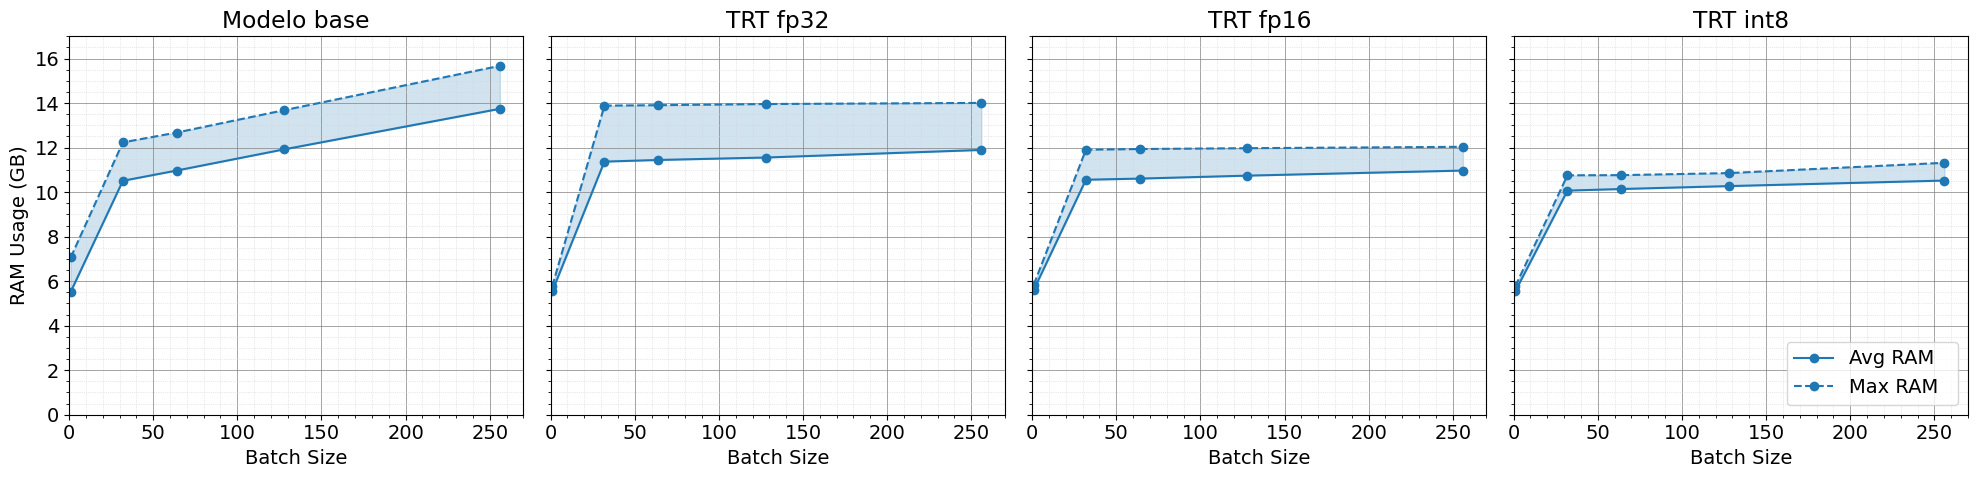

In [158]:
# MEMORY PLOTTER, BASE MODEL | TRT FP32 | TRT FP16 | TRT IN8    

PLATFORM = 'orin_agx'

#OPTIMIZATION
BASE_MODEL = 'vanilla'
FP32 = 'fp32'
FP16 = 'fp16'
INT8 = 'int8'

NETWORK = 'resnet50'
POWER_MODE = 'PM2'
BUILD_TYPE = 'dynamic'
OPLVL = 'OPLVL3'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')

data_bs_1_fp32 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_32_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_64_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_128_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_256_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')

data_bs_1_fp16 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_32_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_64_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_128_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_256_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')

data_bs_1_int8 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_32_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_64_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_128_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_256_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')

plot_memory_horizontal_plots(
    [
        [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
        [ data_bs_1_fp32, data_bs_32_fp32, data_bs_64_fp32,data_bs_128_fp32,data_bs_256_fp32]
        ,[ data_bs_1_fp16, data_bs_32_fp16, data_bs_64_fp16,data_bs_128_fp16,data_bs_256_fp16]
        ,[ data_bs_1_int8, data_bs_32_int8, data_bs_64_int8,data_bs_128_int8,data_bs_256_int8]
        ]
    ],
    [ 1,32,64,128,256],
    ['Modelo base', 'TRT fp32', 'TRT fp16', 'TRT int8'],
    [' ']
)

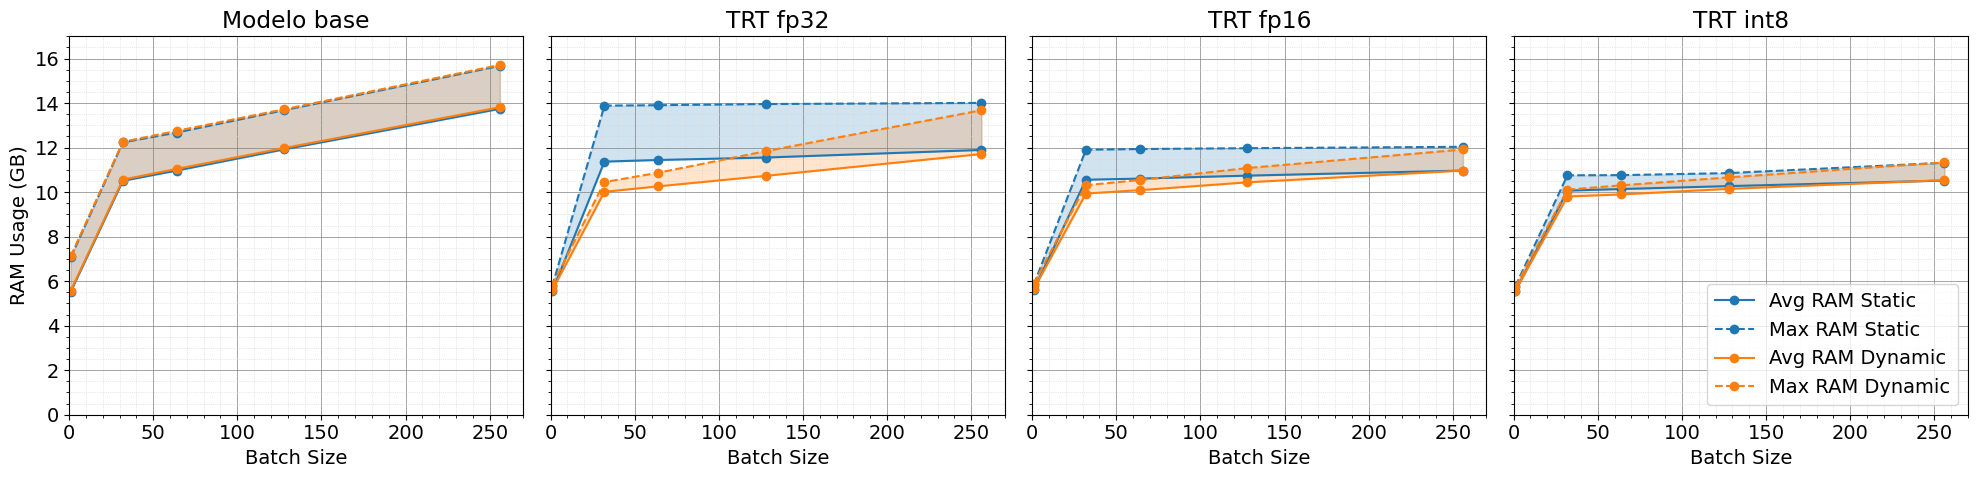

In [159]:
# STATIC VS DYNAMIC MEMORY PLOTTER

PLATFORM = 'orin_agx'

#OPTIMIZATION
BASE_MODEL = 'vanilla'
FP32 = 'fp32'
FP16 = 'fp16'
INT8 = 'int8'

NETWORK = 'resnet50'
POWER_MODE = 'PM2'
DYNAMIC = 'dynamic'
STATIC = 'static'
OPLVL = 'OPLVL3'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_1_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_32_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_64_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_128_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_256_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')

data_bs_1_static =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_1_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_32_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_32_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_64_static= read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_64_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_128_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_128_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_256_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_256_{POWER_MODE}_{STATIC}_{OPLVL}.txt')

data_bs_1_fp32 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_1_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_32_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_32_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_64_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_64_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_128_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_128_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_256_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_256_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')

data_bs_1_fp32_static =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_1_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_32_fp32_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_32_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_64_fp32_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_64_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_128_fp32_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_128_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_256_fp32_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_256_{POWER_MODE}_{STATIC}_{OPLVL}.txt')

data_bs_1_fp16 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_1_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_32_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_32_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_64_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_64_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_128_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_128_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_256_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_256_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')

data_bs_1_fp16_static =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_1_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_32_fp16_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_32_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_64_fp16_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_64_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_128_fp16_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_128_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_256_fp16_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_256_{POWER_MODE}_{STATIC}_{OPLVL}.txt')

data_bs_1_int8 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_1_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_32_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_32_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_64_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_64_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_128_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_128_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')
data_bs_256_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_256_{POWER_MODE}_{DYNAMIC}_{OPLVL}.txt')

data_bs_1_int8_static =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_1_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_32_int8_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_32_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_64_int8_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_64_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_128_int8_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_128_{POWER_MODE}_{STATIC}_{OPLVL}.txt')
data_bs_256_int8_static = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_256_{POWER_MODE}_{STATIC}_{OPLVL}.txt')

plot_memory_horizontal_plots(
    [
        [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
        [ data_bs_1_fp32, data_bs_32_fp32, data_bs_64_fp32,data_bs_128_fp32,data_bs_256_fp32]
        ,[ data_bs_1_fp16, data_bs_32_fp16, data_bs_64_fp16,data_bs_128_fp16,data_bs_256_fp16]
        ,[ data_bs_1_int8, data_bs_32_int8, data_bs_64_int8,data_bs_128_int8,data_bs_256_int8]
        ],
        [[ data_bs_1_static, data_bs_32_static, data_bs_64_static,data_bs_128_static,data_bs_256_static],
        [ data_bs_1_fp32_static, data_bs_32_fp32_static, data_bs_64_fp32_static,data_bs_128_fp32_static,data_bs_256_fp32_static]
        ,[ data_bs_1_fp16_static, data_bs_32_fp16_static, data_bs_64_fp16_static,data_bs_128_fp16_static,data_bs_256_fp16_static]
        ,[ data_bs_1_int8_static, data_bs_32_int8_static, data_bs_64_int8_static,data_bs_128_int8_static,data_bs_256_int8_static]
        ]
    ],
    [ 1,32,64,128,256],
    ['Modelo base', 'TRT fp32', 'TRT fp16', 'TRT int8'],
    ['Static', 'Dynamic']
)


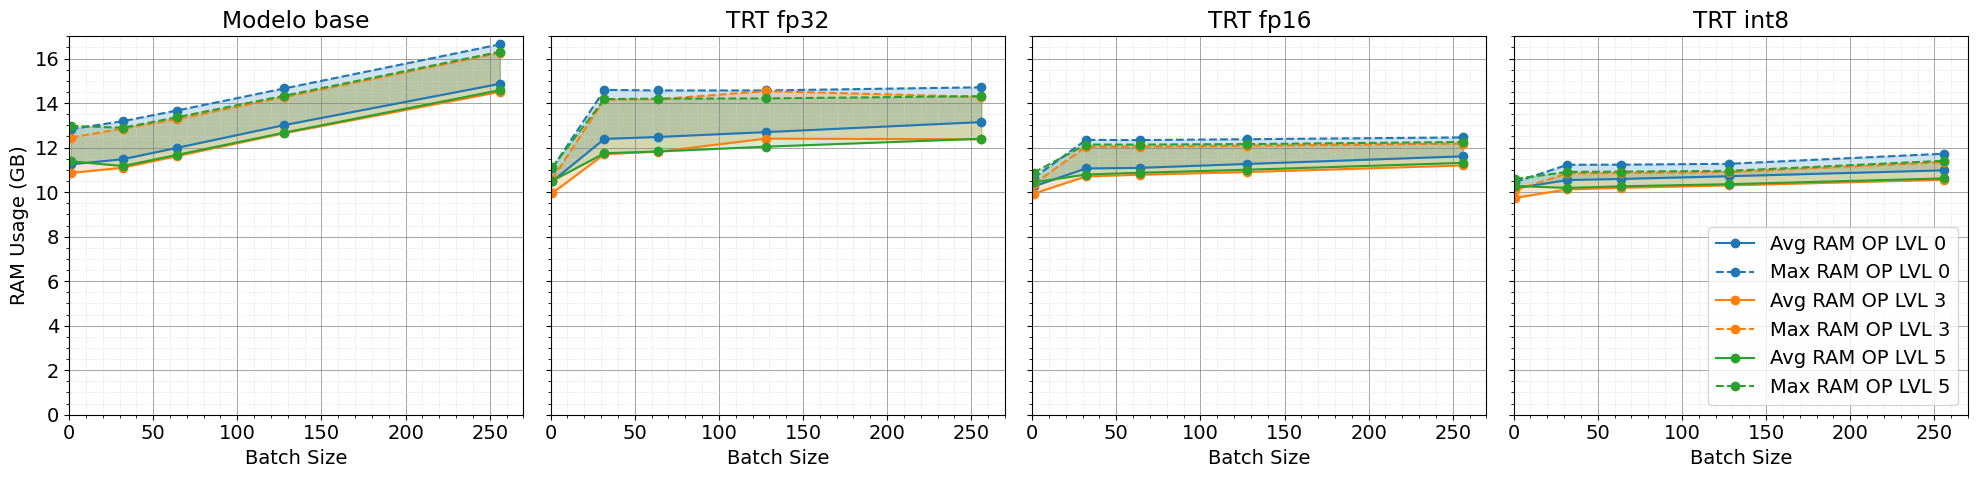

In [160]:
# OPTIMIZATION LEVEL PLOTTER

PLATFORM = 'orin_agx'

#OPTIMIZATION
BASE_MODEL = 'vanilla'
FP32 = 'fp32'
FP16 = 'fp16'
INT8 = 'int8'

NETWORK = 'resnet152'
POWER_MODE = 'PM2'
BUILD_TYPE = 'dynamic'


OPLVL0 = 'OPLVL0'
OPLVL3 = 'OPLVL3'
OPLVL5 = 'OPLVL5'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')

data_bs_1_lvl3 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_32_lvl3 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_64_lvl3 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_128_lvl3 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_256_lvl3 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')

data_bs_1_lvl5 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_32_lvl5 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_64_lvl5 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_128_lvl5 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_256_lvl5 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{BASE_MODEL}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')


data_bs_1_fp32 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_32_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_64_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_128_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_256_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')

data_bs_1_lvl3_fp32 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_32_lvl3_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_64_lvl3_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_128_lvl3_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_256_lvl3_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')

data_bs_1_lvl5_fp32 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_32_lvl5_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_64_lvl5_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_128_lvl5_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_256_lvl5_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP32}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')

data_bs_1_fp16 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_32_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_64_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_128_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_256_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')

data_bs_1_lvl3_fp16 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_32_lvl3_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_64_lvl3_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_128_lvl3_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_256_lvl3_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')

data_bs_1_lvl5_fp16 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_32_lvl5_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_64_lvl5_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_128_lvl5_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_256_lvl5_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{FP16}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')

data_bs_1_int8 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_32_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_64_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_128_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')
data_bs_256_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL0}.txt')

data_bs_1_lvl3_int8 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_32_lvl3_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_64_lvl3_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_128_lvl3_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')
data_bs_256_lvl3_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL3}.txt')

data_bs_1_lvl5_int8 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_32_lvl5_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_64_lvl5_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_128_lvl5_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')
data_bs_256_lvl5_int8 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{INT8}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL5}.txt')

plot_memory_horizontal_plots(
    [
        [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
        [ data_bs_1_fp32, data_bs_32_fp32, data_bs_64_fp32,data_bs_128_fp32,data_bs_256_fp32]
        ,[ data_bs_1_fp16, data_bs_32_fp16, data_bs_64_fp16,data_bs_128_fp16,data_bs_256_fp16]
        ,[ data_bs_1_int8, data_bs_32_int8, data_bs_64_int8,data_bs_128_int8,data_bs_256_int8]
        ],

        [[ data_bs_1_lvl3, data_bs_32_lvl3, data_bs_64_lvl3,data_bs_128_lvl3,data_bs_256_lvl3],
        [ data_bs_1_lvl3_fp32, data_bs_32_lvl3_fp32, data_bs_64_lvl3_fp32,data_bs_128_lvl3_fp32,data_bs_256_lvl3_fp32]
        ,[ data_bs_1_lvl3_fp16, data_bs_32_lvl3_fp16, data_bs_64_lvl3_fp16,data_bs_128_lvl3_fp16,data_bs_256_lvl3_fp16]
        ,[ data_bs_1_lvl3_int8, data_bs_32_lvl3_int8, data_bs_64_lvl3_int8,data_bs_128_lvl3_int8,data_bs_256_lvl3_int8]
        ],


        [[ data_bs_1_lvl5, data_bs_32_lvl5, data_bs_64_lvl5,data_bs_128_lvl5,data_bs_256_lvl5],
        [ data_bs_1_lvl5_fp32, data_bs_32_lvl5_fp32, data_bs_64_lvl5_fp32,data_bs_128_lvl5_fp32,data_bs_256_lvl5_fp32]
        ,[ data_bs_1_lvl5_fp16, data_bs_32_lvl5_fp16, data_bs_64_lvl5_fp16,data_bs_128_lvl5_fp16,data_bs_256_lvl5_fp16]
        ,[ data_bs_1_lvl5_int8, data_bs_32_lvl5_int8, data_bs_64_lvl5_int8,data_bs_128_lvl5_int8,data_bs_256_lvl5_int8]
        ]
    ],
    [ 1,32,64,128,256],
    ['Modelo base', 'TRT fp32', 'TRT fp16', 'TRT int8'],
    ['OP LVL 0', 'OP LVL 3', 'OP LVL 5']
)


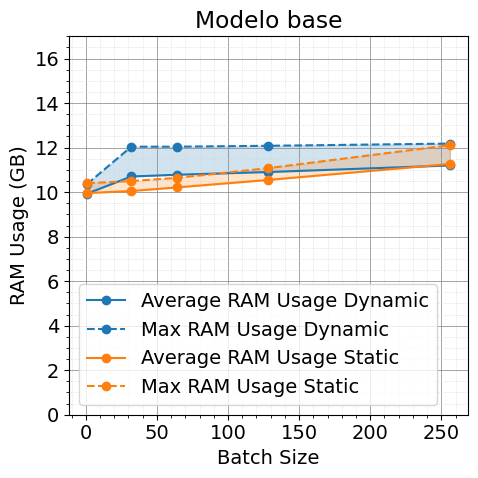

In [161]:
# COMPARE TWO MEMORY TESTS

PLATFORM = 'orin_agx'

OPTIMIZATION = 'fp16'

NETWORK = 'resnet152'

POWER_MODE = 'PM2'
POWER_MODE_1 = 'PM2'

BUILD_TYPE = 'dynamic'
BUILD_TYPE_2 = 'static'

OPLVL = 'OPLVL3'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE}_{BUILD_TYPE}_{OPLVL}.txt')

data_bs_1_PM =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE_1}_{BUILD_TYPE_2}_{OPLVL}.txt')
data_bs_32_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE_1}_{BUILD_TYPE_2}_{OPLVL}.txt')
data_bs_64_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE_1}_{BUILD_TYPE_2}_{OPLVL}.txt')
data_bs_128_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE_1}_{BUILD_TYPE_2}_{OPLVL}.txt')
data_bs_256_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE_1}_{BUILD_TYPE_2}_{OPLVL}.txt')


# Graficar los datos 
plot_memory_single_figure(
    [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
    [ data_bs_1_PM, data_bs_32_PM, data_bs_64_PM,data_bs_128_PM,data_bs_256_PM]
    #,[ data_bs_1_PM2, data_bs_32_PM2, data_bs_64_PM2,data_bs_128_PM2,data_bs_256_PM2]
    ],
    [ 1,32,64,128,256]
    ,['Dynamic', 'Static'],
    "Modelo base"
)
